# Classifying Claims - Generating X and Y.

In this post we will look at manually converting our claim text and claim categories into a form suitable for applying deep learning algorithms. 

If you don't have access to the USPTO downloads you can start from here using the pickle file in the GitHub directory.

We will be using USPTO data, where the claims are classified according to the International Patent Classification (IPC). To keep things simple we will use the first letter of the IPC (top level category). This is the same as the top level of the Cooperative Patent Classification (CPC).  

The list of top level categories can be found here: https://rs.espacenet.com/help?locale=en_EP&method=handleHelpTopic&topic=ipc:
* A Human Necessities
* B Performing Operations; Transporting
* C Chemistry; Metallurgy
* D Textiles; Paper
* E Fixed Constructions
* F Mechanical Engineering; Lighting; Heating; Weapons; Blasting Engines or Pumps
* G Physics
* H Electricity

---
Machine learning algorithms generally work with numbers (typically floats of 32 or 64 bits). These numbers are arranged in multi-dimensional arrays called tensors. 

Most machine learning algorithms expects a training set of data to be formatted into an 'X' tensor. One dimension of this tensor represents the different training samples. Another set of dimenions then represent the data of each training sample. For example, if each claim was represented as a one-dimensional vector [3, 1, 2, ..., 3] then X might comprise a matrix where rows of the matrix represent different samples and the columns of the matrix represent different features of the sample.  

For classification tasks each sample has an associated label. These are typically expected in a 'Y' tensor. Again, one dimension of this tensor represents the different training samples, while another set of dimensions represents the actual classification value for a particular sample. For example, in a simple binary case, Y may comprise a vector of 0 or 1 values. 

In this post we will look at how to shape numeric X and Y vectors based on our "claim and classification" data. In other posts we may use built in functions of machine learning libraries to do this for us.

---
Let's start by loading the data we saved previously in the "Getting the Data" post. 

In [1]:
import pickle, os

with open("raw_data.pkl", "rb") as f:
    raw_data = pickle.load(f)
    
print("There are {0} data samples. Here is an example:\n".format(len(raw_data)))
print(raw_data[0])

There are 11238 data samples. Here is an example:

('\n1. A detector for atrial fibrillation or flutter (AF) comprising: \nan impedance measuring unit comprising a measuring input, to which an atrial electrode line having an electrode for a unipolar measurement of an impedance in an atrium is connected and is implemented to generate an atrial impedance signal, obtained in a unipolar manner, in such a way that an impedance signal for each atrial cycle, comprising an atrial contraction and a following relaxation of said atrium, comprises multiple impedance values detected at different instants within a particular atrial cycle; \nsaid impedance measuring unit comprising a signal input, via which a ventricle signal is to be supplied to said detector, which reflects instants of ventricular contractions in chronological assignment to said impedance signal; \nan analysis unit configured to average multiple sequential impedance signal sections of a unipolar atrial impedance signal, which are e

## Tokenising into Words and Building a Dictionary

Now we need to split our claim text into word tokens and build a dictionary of words.

We will start by using NLTK word_tokenize out of the box. This breaks our long string of claim text into a list of tokens. These tokens, most of the time, should correspond to "words" (although occasionally errors may creep in).

In [2]:
from nltk import word_tokenize

data_in_words = [(word_tokenize(d[0]), d[1]) for d in raw_data]

In [3]:
# Here is an example
data_in_words[55]

(['1',
  '.',
  'A',
  'sensing',
  'assembly',
  'for',
  'sensing',
  'a',
  'level',
  'of',
  'liquid',
  'in',
  'a',
  'reservoir',
  ',',
  'said',
  'sensing',
  'assembly',
  'comprising',
  ':',
  'a',
  'first',
  'input',
  'port',
  'for',
  'receiving',
  'a',
  'first',
  'input',
  'voltage',
  'signal',
  ';',
  'a',
  'second',
  'input',
  'port',
  'for',
  'receiving',
  'a',
  'second',
  'input',
  'voltage',
  'signal',
  ';',
  'an',
  'excitation',
  'circuit',
  'electrically',
  'connected',
  'to',
  'said',
  'first',
  'and',
  'second',
  'input',
  'ports',
  'for',
  'receiving',
  'the',
  'first',
  'and',
  'second',
  'input',
  'voltage',
  'signals',
  'and',
  'for',
  'generating',
  'a',
  'first',
  'excitation',
  'signal',
  'and',
  'a',
  'second',
  'excitation',
  'signal',
  ',',
  'said',
  'excitation',
  'circuit',
  'includes',
  'first',
  'and',
  'second',
  'excitation',
  'electrodes',
  'extending',
  'along',
  'a',
  'porti

In [4]:
# What is our maximum claim length?
print("Max claim length = {0}".format(max([len(d[0]) for d in data_in_words])))

Max claim length = 6134


That's long! 6134 words.   

Let's have a look at how the length (in words) of our claims is distributed.

In [5]:
from collections import Counter

claim_length_counter = Counter([len(d[0]) for d in data_in_words])

We can quickly have a look at a histogram of the lengths.

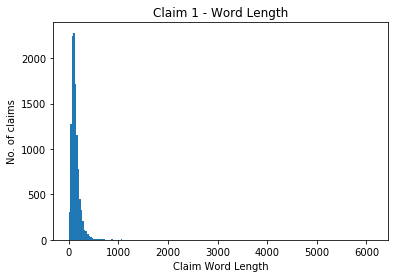

In [6]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

bins = np.linspace(0, max(claim_length_counter.elements()), 200)
plt.hist(list(claim_length_counter.elements()), bins)
plt.title('Claim 1 - Word Length')
plt.ylabel('No. of claims');
plt.xlabel('Claim Word Length');

As we can see the 6134 length claim is a clear outlier. The distribution is focused around 0 to around 600 words. Let's zoom in on that.

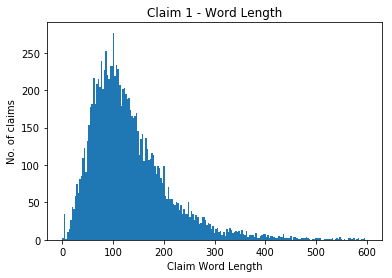

In [7]:
bins = np.linspace(0, 600, 200)
plt.hist(list(claim_length_counter.elements()), bins)
plt.title('Claim 1 - Word Length')
plt.ylabel('No. of claims');
plt.xlabel('Claim Word Length');

When applying deep learning algorithms we often need to set a maximum sequence length. When dealing with words, this is equal to the maximum number of words expected in a claim. A lower maximum sequence length will help reduce our training time. 

If we take all claims of less than 250 words this would still include most of the data.  

In [8]:
# We might want to filter all claims over 250 tokens long
filtered_data = [d for d in data_in_words if len(d[0]) <= 250]
print("There are now {0} claims after removing long claims".format(len(filtered_data)))

There are now 10262 claims after removing long claims


In [ ]:
# Let's clear some memory
del data_in_words

---
Now let's have a look at the words themselves.

In [ ]:
# Look at the words in our claims
word_counter = Counter(sum([d[0] for d in filtered_data], list()))
print("There are {0} different tokens in our dataset.\n".format(len(word_counter)))
print("The 100 most common words are:", word_counter.most_common(50))

In [ ]:
print("The 100 least common words are:", word_counter.most_common()[:-100-1:-1] )

In [ ]:
# Save some of these to use later
with open("word_counter.pkl", "wb") as f:
    pickle.dump(word_counter, f)
with open("filtered_data.pkl", "wb") as f:
    pickle.dump(filtered_data, f)

Below is a function that takes our raw data and generates X and Y tensors. It is based on one provided in the Udacity Deep Learning course.

First a filtering function is applied to only select claims below a certain word length. A default setting is to remove claims that have more than 250 words.

The X tensor is generated by replacing each word with an integer, the integer representing an integer in a dictionary of words. A vocabulary size is passed as a parameter, which sets the maximum size of the dictionary based on the most frequent words. Words that are not in the dictionary (e.g. because they occur too infrequently) are replaced with a special UNK token.

The integer value 0 is also reserved for a special PAD token. We will need this when we come to pad our data later.

The Y tensor replaces each of the A to H categories with an integer value from 0 to 7.  

Forward and reverse dictionaries are returned, which can be used to map to and from text to integer values.

In [ ]:
# Now bringing this all together a little

def build_dataset(raw_data, length_filter=250, vocabulary_size=25000):
    """ Convert raw data in the form of (claim_text, class) into 
    X, Y format where X is numeric data and Y is label data.
    
    length_filter is a parameter to filter by token length 
    (e.g. to exclude long claims)."""
    # Tokenise and filter
    raw_data = [(word_tokenize(d[0]), d[1]) for d in raw_data]
    raw_data = [d for d in raw_data if len(d[0]) <= length_filter]
    
    # Create labels first
    Y_text = [d[1] for d in raw_data]
    class_dictionary = {c: i for i, c in enumerate(sorted(Counter(Y_text).keys()))} 
    Y_data = [class_dictionary[y_text] for y_text in Y_text]
    reverse_class_dictionary = dict(zip(class_dictionary.values(), class_dictionary.keys()))
    
    # Create X in text
    X_text = [d[0] for d in raw_data]
    
    # Change to lowercase
    X_text = [[word.lower() for word in x_text] for x_text in X_text]
    
    # Create complete wordset for dictionary generation
    words = sum(X_text, list())
    # Reserve slots for PAD and UNK tokens
    count = [('PAD', 0), ['UNK', -1]]
    count.extend(Counter(words).most_common(vocabulary_size - 2))
    
    # Build dictionary
    word_dictionary = {word: i for i, (word, _) in enumerate(count)}
        
    # Build X in indexes
    X_data = list()
    unk_count = 0
    # Go through claims replacing words with index 
    for x_text in X_text:
        x_data = list()
        for word in x_text:
            if word in word_dictionary:
                index = word_dictionary[word]
            else:
                index = 1  # dictionary['UNK']
                unk_count = unk_count + 1
            x_data.append(index)
        X_data.append(x_data)
        
    count[1][1] = unk_count
    reverse_word_dictionary = dict(zip(word_dictionary.values(), word_dictionary.keys())) 
    
    return X_data, Y_data, count, word_dictionary, reverse_word_dictionary, class_dictionary, reverse_class_dictionary

Now we run this function on the raw data and save the result.

In [ ]:
filename = "X_Y_data.pkl"

if os.path.isfile(filename):
    with open(filename, "rb") as f:
        print("Loading data")
        X_data, Y_data, count, word_dictionary, reverse_word_dictionary, class_dictionary, reverse_class_dictionary = pickle.load(f)
else:
    X_data, Y_data, count, word_dictionary, reverse_word_dictionary, class_dictionary, reverse_class_dictionary = build_dataset(raw_data)
    print('Most common words (+UNK)', count[:5])
    print('Sample data', X_data[0], Y_data[0])
    with open(filename, "wb") as f:
        data = (X_data, Y_data, count, word_dictionary, reverse_word_dictionary, class_dictionary, reverse_class_dictionary)
        pickle.dump(data, f)

As you can see our word dictionary has 25000 entries, as set by the vocabulary.

In [ ]:
len(word_dictionary)

Let's look at some examples - "the" is replace with the integer value 2 and "computer" is replaced with an integer value of 143.

In [ ]:
word_dictionary["the"]

In [ ]:
word_dictionary["computer"]

As you can see below, each claim now becomes a list of integers representing the words within the claim.

In [ ]:
X_data[0]

Let's also have a look at our dictionary for the classification categories and some example values.

In [ ]:
class_dictionary

In [ ]:
reverse_class_dictionary

In [ ]:
Y_data[0:5]

In [ ]:
# Check vectors are the same length
print(len(X_data), len(Y_data))

One issue we still have is that each sample in our X data has a different length. Most machine learning libraries need all samples to have the same length for training. To convert our X data to a series of vectors of a fixed length we can set a maximum vector size and then pad the different between the maximum vector size and our given claims.  

In our function above the maximum claim length is set to 250 words. This can therefore become our maximum vector size.  

Keras provides a helpful preprocessing function to provide this padding. We also need to convert our data to numpy arrays.

We also split our data into training data and test data. The training data is used to train our model. The test data is used to evaluate our model.

In [ ]:
# First we need to split out data into training and test data - go for 80:20
import numpy as np

from keras.preprocessing import sequence
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split

# seed for reproducing same results
seed = 9
np.random.seed(seed)

# split the data into training (80%) and testing (20%)
(X_train, X_test, Y_train, Y_test) = train_test_split(X_data, Y_data, test_size=0.2, random_state=seed)

In [ ]:
# Now we need to segment and pad our claim text sequences - we have already restricted our claims to length 250
# We might want to experiment with changing this
max_word_length = 250
# Padding is performing by adding 0, which we have reserved as a PAD token above
X_train = sequence.pad_sequences(X_train, maxlen=max_word_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_word_length)

In [ ]:
print("Our training data has length: {0} and our test data has length: {1}".format(len(X_train), len(X_test)))

Here is an example of our padded data.

In [ ]:
X_train[1]

In [ ]:
no_classes = len(class_dictionary)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
print("There are {0} classes".format(no_classes))

In [ ]:
Y_train.shape

In order to compare an output vector of our deep learning models with our labels we need to convert our integer labels to what are called "one-hot" encodings. These are vectors with a length equal to the number of labels; an index set to 1 in the vector indicates that the label is the integer value associated with the index.

In [ ]:
# Convert labels to categorical one-hot encoding
Y_train = to_categorical(Y_train, num_classes=no_classes)
Y_test = to_categorical(Y_test, num_classes=no_classes)

In [ ]:
Y_train[0]

In [ ]:
print(X_train.shape, X_test.shape)

In [ ]:
print(Y_train.shape, Y_test.shape)

So we now have X_train and X_test tensors in matrix form (8209/2053 samples of length 250), and Y_train and Y_test tensors in one hot-form (of size 8209/2053 by 8).  

We now have everything we need to train and test some deep learning models. We will do this in another notebook.